In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join, basename
import numpy as np

In [2]:
class ExpDataStruct:
    def __init__(self):
        self.curr_dens = 0
        self.temp = 0
        self.humidity = 0
        self.data = 0
        self.params = 0
        self.pol_fwd = 0
        self.pol_rev = 0
        self.name = ''

In [3]:
def get_data(filename):
    """
This method helps to retrieve data from existing
excel file with full pathname "filename"
    """
    dt = pd.read_excel(filename, sheetname=0, header=None,)
    df = pd.DataFrame(data=dt, index=None)

    # check for the file type
    if df.iloc[0, 0] == 'Current density (mA/cm2)':  # this is EIS data

        eis_data = ExpDataStruct()  # initializes the struct for eis_data

        name = basename(filename)
        curr_dens = df.iloc[0, 1]  # grabs the current density for the EIS data
        col_name = df.iloc[1, :].tolist()

        # clean eis data
        data = df
        data.columns = col_name
        data = data.dropna(how='any')
        data = data[1:]
        data = data.reset_index(drop=True)

        # populate the eis_data struct
        eis_data.data = data
        eis_data.curr_dens = curr_dens
        eis_data.name = name

        exp_data = eis_data  # assign populated eis_data struct to return variable

    elif df.iloc[0, 0] == 'Set point values':  # this is polarisation curve data

        pol_data = ExpDataStruct()

        # clean parameter portion of the data
        params = df.iloc[:, 0:2]
        params = params.dropna(how='any')
        params.columns = ['set point', 'value']
        params = params.reset_index(drop=True)
        
        name = basename(filename)
        
        # clean pol_fwd portion of the data
        pol_fwd = df.iloc[:, 3:9]
        pol_fwd = pol_fwd.dropna(how='any')
        pol_fwd.columns = ['cell temp C', 'curr_den', 'v1', 'v2', 'v3', 'avg_volt']
        pol_fwd = pol_fwd.reset_index(drop=True)

        # clean pol_reverse portion of the data
        pol_rev = df.iloc[:, 10:16]
        pol_rev = pol_rev.dropna(how='any')
        pol_rev.columns = ['cell temp C', 'curr_den', 'v1', 'v2', 'v3', 'avg_volt']
        pol_rev = pol_rev.reset_index(drop=True)

        # populate the pol_data struct
        pol_data.params = params
        pol_data.pol_fwd = pol_fwd
        pol_data.pol_rev = pol_rev
        pol_data.name = name

        exp_data = pol_data  # assign populated pol_data struct to return variable

    return exp_data

In [4]:
def add_var(eis_data):
    """
    This methods computes other variables from the eis_data.data columns
    The variables extend the number of column if the data.
    """
    # calculate magnitude
    re = np.float64(eis_data.data['Imp Re'])
    img = np.float64(eis_data.data['Imp i'])
    re_img = np.array([re, img])
    #eis_data.data['Mag'] = np.sqrt((eis_data.data['Imp Re'])**2 + (eis_data.data['Imp i'])**2)
    eis_data.data['Mag'] = np.sqrt(re**2 + img**2)
    eis_data.data['Phase'] = np.arctan(img/re)
    
    return eis_data

In [5]:
# gets the full paths to the experiment file from the exp_path directory
exp_path = "C:\\Users\Aroogz\Desktop\Work - UCT\PG\Data\\exp_2\\"

exp_files = []
for f in listdir(exp_path):
    if isfile(join(exp_path, f)):
        exp_files.append(join(exp_path, f))

# Looking and picking out polarisation and EIS files
exp_files_pol = []
exp_files_eis = []
for path in exp_files:
    if 'Polarisation' in path:
        exp_files_pol.append(path)
    elif 'EIS' in path:
        exp_files_eis.append(path)
    else:
        pass


## Drawing the Polarisation curves

In [6]:
# utilizes the getdata method to clean up each pol. file in exp_files_pol
# each file is now a struct and an item in the pols list
pols = []
for path in exp_files_pol:
    pols.append(get_data(path))


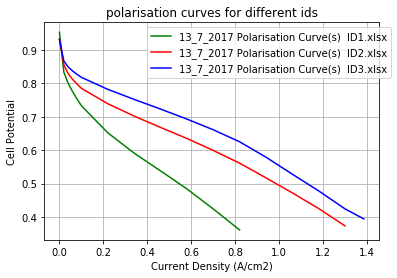

,cell temp C,curr_den,v1,v2,v3,avg_volt
0,78.4,8e-05,0.954,0.953,0.952,0.953
1,77.6,0.02008,0.834,0.834,0.834,0.834
2,77.5,0.03992,0.8,0.800,0.800,0.8
3,77.9,0.06012,0.775,0.775,0.775,0.775
4,78.5,0.08002,0.753,0.753,0.753,0.753
5,79.2,0.1,0.733,0.733,0.733,0.733
6,79.7,0.22,0.653,0.652,0.651,0.652
7,80.2,0.34,0.591,0.591,0.591,0.591
8,80.5,0.45992,0.538,0.538,0.539,0.538
9,80.9,0.57994,0.483,0.484,0.485,0.484


In [7]:
import matplotlib.pyplot as plt

pol0 = pols[0]
pol1 = pols[1]
pol2 = pols[2]

pol0_data = pol0.pol_fwd
pol1_data = pol1.pol_fwd
pol2_data = pol2.pol_fwd

id0, = plt.plot(pol0_data.iloc[:, 1], pol0_data.iloc[:, 5], 'g')
id1, = plt.plot(pol1_data.iloc[:, 1], pol1_data.iloc[:, 5], 'r')
id2, = plt.plot(pol2_data.iloc[:, 1], pol2_data.iloc[:, 5], 'b')

plt_names = [pol0.name, pol1.name, pol2.name]

plt.legend([id0, id1, id2], plt_names, bbox_to_anchor=(1.05, 1))
plt.xlabel('Current Density (A/cm2)')
plt.ylabel('Cell Potential')
plt.title('polarisation curves for different ids')

plt.grid(True)
plt.show()

pol0_data

## Drawing the EIS plots

In [8]:
# utilizes the getdata method to clean up each eis data file in exp_files_eis
# each file is now a struct and an item in the eis list
eis = []
for path in exp_files_eis:
    var = get_data(path)
    var = add_var(var)
    eis.append(var)

len(eis)

9

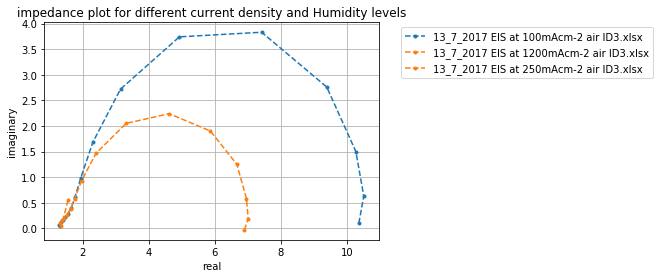

,Frequency (Hz),Imp Re,Imp i,Mag,Phase
0,0.1,14.41,-0.67,14.425568,-0.046462
1,0.3,14.99,-0.38,14.994816,-0.025345
2,0.7,15.39,-0.02,15.390013,-0.001300
3,1.5,15.54,0.55,15.549730,0.035378
4,3.1,15.31,1.48,15.381369,0.096369
5,6.3,14.52,2.76,14.779986,0.187842
6,12.7,12.83,4.09,13.466143,0.308600
7,25.5,10.22,4.83,11.303862,0.441491
8,51.1,7.58,4.48,8.804930,0.533797
9,102.3,5.6,3.45,6.577424,0.552153


In [37]:
eis0 = eis[0]
eis1 = eis[1]
eis2 = eis[2]
eis3 = eis[3]
eis4 = eis[4]
eis5 = eis[5]
eis6 = eis[6]
eis7 = eis[7]
eis8 = eis[8]

eis0_data = eis0.data
eis1_data = eis1.data
eis2_data = eis2.data
eis3_data = eis3.data
eis4_data = eis4.data
eis5_data = eis5.data
eis6_data = eis6.data
eis7_data = eis7.data
eis8_data = eis8.data

#id0, = plt.plot(eis0_data.iloc[:, 1], eis0_data.iloc[:, 2], '.--')
#id1, = plt.plot(eis1_data.iloc[:, 1], eis1_data.iloc[:, 2], '.--')
id2, = plt.plot(eis2_data.iloc[:, 1], eis2_data.iloc[:, 2], '.--')
#id3, = plt.plot(eis3_data.iloc[:, 1], eis3_data.iloc[:, 2], '.--')
#id4, = plt.plot(eis4_data.iloc[:, 1], eis4_data.iloc[:, 2], '.--')

#id5, = plt.plot(eis5_data.iloc[:, 1], eis5_data.iloc[:, 2], '.--')
#id6, = plt.plot(eis6_data.iloc[:, 1], eis6_data.iloc[:, 2], '.--')
#id7, = plt.plot(eis7_data.iloc[:, 1], eis7_data.iloc[:, 2], '.--')
id8, = plt.plot(eis8_data.iloc[:, 1], eis8_data.iloc[:, 2], '.--')

# plt_names = [eis0.name, eis1.name, eis2.name, eis3.name, eis4.name,
#             eis5.name, eis6.name, eis7.name, eis8.name]

plt_names = [eis2.name, eis5.name, eis8.name]
# plt.legend([id0, id1, id2, id3, id4, id5, id6, id7, id8], plt_names, bbox_to_anchor=(1.05, 1))
plt.legend([id2, id5, id8], plt_names, bbox_to_anchor=(1.05, 1))


plt.xlabel('real')
plt.ylabel('imaginary')
plt.title('impedance plot for different current density and Humidity levels')

plt.grid(True)
plt.show()

eis1_data

In [ ]:
id0, = plt.plot(eis0_data.iloc[:, 1], eis0_data.iloc[:, 2], '.--')
id1, = plt.plot(eis1_data.iloc[:, 1], eis1_data.iloc[:, 2], '.--')
id2, = plt.plot(eis2_data.iloc[:, 1], eis2_data.iloc[:, 2], '.--')

plt_names = [ eis0.name, eis1.name, eis2.name]
#plt.legend([id0, id1, id2, id3, id4, id5, id6, id7, id8], plt_names, bbox_to_anchor=(1.05, 1))
plt.legend([id0, id1, id2],  plt_names, bbox_to_anchor=(1.05, 1))

plt.xlabel('real')
plt.ylabel('imaginary')
plt.title('impedance plot for different current density and Humidity levels')

plt.grid(True)
plt.show()


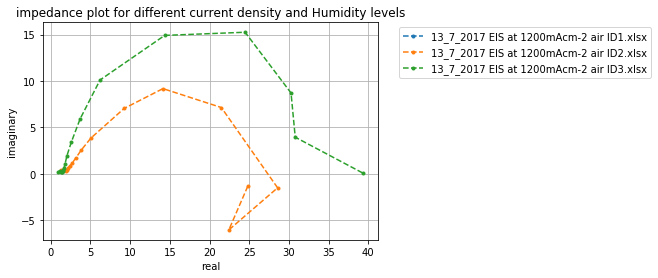

In [25]:
id3, = plt.plot(eis3_data.iloc[:, 1], eis3_data.iloc[:, 2], '.--')
id4, = plt.plot(eis4_data.iloc[:, 1], eis4_data.iloc[:, 2], '.--')
id5, = plt.plot(eis5_data.iloc[:, 1], eis5_data.iloc[:, 2], '.--')

plt_names = [ eis3.name, eis4.name, eis5.name]
#plt.legend([id0, id1, id2, id3, id4, id5, id6, id7, id8], plt_names, bbox_to_anchor=(1.05, 1))
plt.legend([id3, id4, id5],  plt_names, bbox_to_anchor=(1.05, 1))

plt.xlabel('real')
plt.ylabel('imaginary')
plt.title('impedance plot for different current density and Humidity levels')

plt.grid(True)
plt.show()

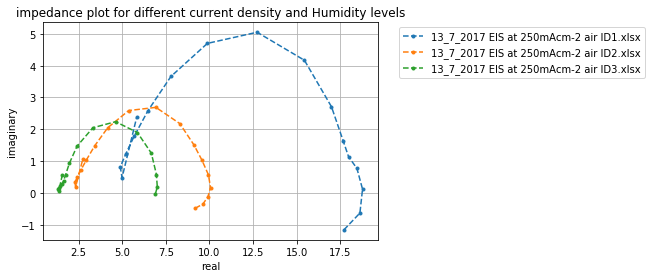

In [26]:
id6, = plt.plot(eis6_data.iloc[:, 1], eis6_data.iloc[:, 2], '.--')
id7, = plt.plot(eis7_data.iloc[:, 1], eis7_data.iloc[:, 2], '.--')
id8, = plt.plot(eis8_data.iloc[:, 1], eis8_data.iloc[:, 2], '.--')

plt_names = [ eis6.name, eis7.name, eis8.name]
plt.legend([id6, id7, id8],  plt_names, bbox_to_anchor=(1.05, 1))

plt.xlabel('real')
plt.ylabel('imaginary')
plt.title('impedance plot for different current density and Humidity levels')

plt.grid(True)
plt.show()

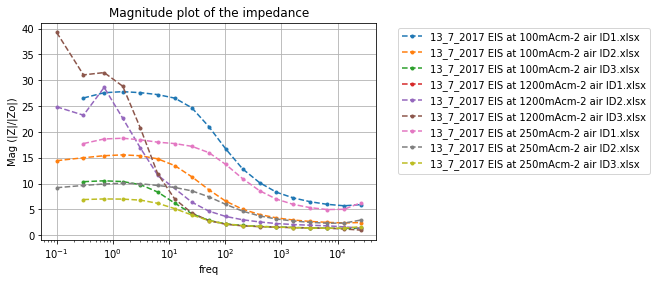

,Frequency (Hz),Imp Re,Imp i,Mag,Phase
0,0.3,26.54,-1.19,26.566665,-0.044808
1,0.7,27.58,-0.53,27.585092,-0.019214
2,1.5,27.79,0.35,27.792204,0.012594
3,3.1,27.57,1.25,27.598322,0.045308
4,6.3,27.12,2.33,27.219906,0.085704
5,12.7,26.21,4.15,26.536514,0.157033
6,25.5,23.78,6.56,24.668239,0.269167
7,51.1,19.41,8.1,21.032311,0.395340
8,102.3,14.82,7.7,16.700970,0.479179
9,204.7,11.29,6.08,12.823046,0.493994


In [38]:
eis0 = eis[0]
eis1 = eis[1]
eis2 = eis[2]
eis3 = eis[3]
eis4 = eis[4]
eis5 = eis[5]
eis6 = eis[6]
eis7 = eis[7]
eis8 = eis[8]

eis0_data = eis0.data
eis1_data = eis1.data
eis2_data = eis2.data
eis3_data = eis3.data
eis4_data = eis4.data
eis5_data = eis5.data
eis6_data = eis6.data
eis7_data = eis7.data
eis8_data = eis8.data

id0, = plt.semilogx(eis0_data.iloc[:, 0], eis0_data.iloc[:, 3], '.--')
id1, = plt.semilogx(eis1_data.iloc[:, 0], eis1_data.iloc[:, 3], '.--')
id2, = plt.semilogx(eis2_data.iloc[:, 0], eis2_data.iloc[:, 3], '.--')
id3, = plt.semilogx(eis3_data.iloc[:, 0], eis3_data.iloc[:, 3], '.--')
id4, = plt.semilogx(eis4_data.iloc[:, 0], eis4_data.iloc[:, 3], '.--')
id5, = plt.semilogx(eis5_data.iloc[:, 0], eis5_data.iloc[:, 3], '.--')
id6, = plt.semilogx(eis6_data.iloc[:, 0], eis6_data.iloc[:, 3], '.--')
id7, = plt.semilogx(eis7_data.iloc[:, 0], eis7_data.iloc[:, 3], '.--')
id8, = plt.semilogx(eis8_data.iloc[:, 0], eis8_data.iloc[:, 3], '.--')

plt_names = [eis0.name, eis1.name, eis2.name, eis3.name, eis4.name,
            eis5.name, eis6.name, eis7.name, eis8.name]

plt.legend([id0, id1, id2, id3, id4, id5, id6, id7, id8], 
           plt_names, bbox_to_anchor=(1.05, 1))

plt.xlabel('freq')
plt.ylabel('Mag (|Z|/|Zo|)')
plt.title('Magnitude plot of the impedance')

plt.grid(True)
plt.show()
eis0_data

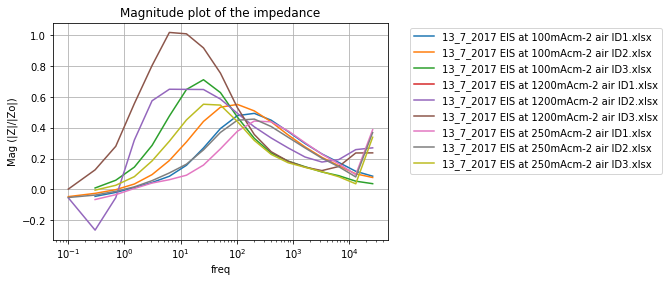

,Frequency (Hz),Imp Re,Imp i,Mag,Phase
0,0.3,26.54,-1.19,26.566665,-0.044808
1,0.7,27.58,-0.53,27.585092,-0.019214
2,1.5,27.79,0.35,27.792204,0.012594
3,3.1,27.57,1.25,27.598322,0.045308
4,6.3,27.12,2.33,27.219906,0.085704
5,12.7,26.21,4.15,26.536514,0.157033
6,25.5,23.78,6.56,24.668239,0.269167
7,51.1,19.41,8.1,21.032311,0.395340
8,102.3,14.82,7.7,16.700970,0.479179
9,204.7,11.29,6.08,12.823046,0.493994


In [12]:
eis0 = eis[0]
eis1 = eis[1]
eis2 = eis[2]
eis3 = eis[3]
eis4 = eis[4]
eis5 = eis[5]
eis6 = eis[6]
eis7 = eis[7]
eis8 = eis[8]

eis0_data = eis0.data
eis1_data = eis1.data
eis2_data = eis2.data
eis3_data = eis3.data
eis4_data = eis4.data
eis5_data = eis5.data
eis6_data = eis6.data
eis7_data = eis7.data
eis8_data = eis8.data

id0, = plt.semilogx(eis0_data.iloc[:, 0], eis0_data.iloc[:, 4], '-')
id1, = plt.semilogx(eis1_data.iloc[:, 0], eis1_data.iloc[:, 4], '-')
id2, = plt.semilogx(eis2_data.iloc[:, 0], eis2_data.iloc[:, 4], '-')
id3, = plt.semilogx(eis3_data.iloc[:, 0], eis3_data.iloc[:, 4], '-')
id4, = plt.semilogx(eis4_data.iloc[:, 0], eis4_data.iloc[:, 4], '-')
id5, = plt.semilogx(eis5_data.iloc[:, 0], eis5_data.iloc[:, 4], '-')
id6, = plt.semilogx(eis6_data.iloc[:, 0], eis6_data.iloc[:, 4], '-')
id7, = plt.semilogx(eis7_data.iloc[:, 0], eis7_data.iloc[:, 4], '-')
id8, = plt.semilogx(eis8_data.iloc[:, 0], eis8_data.iloc[:, 4], '-')

plt_names = [eis0.name, eis1.name, eis2.name, eis3.name, eis4.name,
            eis5.name, eis6.name, eis7.name, eis8.name]

plt.legend([id0, id1, id2, id3, id4, id5, id6, id7, id8], 
           plt_names, bbox_to_anchor=(1.05, 1))

plt.xlabel('freq')
plt.ylabel('Mag (|Z|/|Zo|)')
plt.title('Magnitude plot of the impedance')

plt.grid(True)
plt.show()
eis0_data

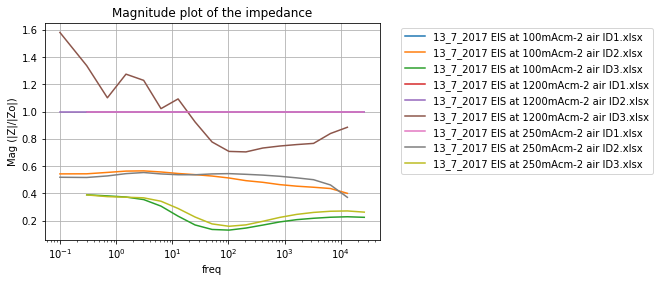

,Frequency (Hz),Imp Re,Imp i,Mag,Phase
0,0.3,26.54,-1.19,26.566665,-0.044808
1,0.7,27.58,-0.53,27.585092,-0.019214
2,1.5,27.79,0.35,27.792204,0.012594
3,3.1,27.57,1.25,27.598322,0.045308
4,6.3,27.12,2.33,27.219906,0.085704
5,12.7,26.21,4.15,26.536514,0.157033
6,25.5,23.78,6.56,24.668239,0.269167
7,51.1,19.41,8.1,21.032311,0.395340
8,102.3,14.82,7.7,16.700970,0.479179
9,204.7,11.29,6.08,12.823046,0.493994


In [13]:
eis0 = eis[0]
eis1 = eis[1]
eis2 = eis[2]
eis3 = eis[3]
eis4 = eis[4]
eis5 = eis[5]
eis6 = eis[6]
eis7 = eis[7]
eis8 = eis[8]

eis0_data = eis0.data
eis1_data = eis1.data
eis2_data = eis2.data
eis3_data = eis3.data
eis4_data = eis4.data
eis5_data = eis5.data
eis6_data = eis6.data
eis7_data = eis7.data
eis8_data = eis8.data

id0, = plt.semilogx(eis0_data.iloc[:, 0], eis0_data.iloc[:, 3]/eis0_data.iloc[:, 3], '-')
id1, = plt.semilogx(eis1_data.iloc[:, 0], eis1_data.iloc[:, 3]/eis0_data.iloc[:, 3], '-')
id2, = plt.semilogx(eis2_data.iloc[:, 0], eis2_data.iloc[:, 3]/eis0_data.iloc[:, 3], '-')
id3, = plt.semilogx(eis3_data.iloc[:, 0], eis3_data.iloc[:, 3], '-')
id4, = plt.semilogx(eis4_data.iloc[:, 0], eis4_data.iloc[:, 3]/eis4_data.iloc[:, 3], '-')
id5, = plt.semilogx(eis5_data.iloc[:, 0], eis5_data.iloc[:, 3]/eis4_data.iloc[:, 3], '-')
id6, = plt.semilogx(eis6_data.iloc[:, 0], eis6_data.iloc[:, 3]/eis6_data.iloc[:, 3], '-')
id7, = plt.semilogx(eis7_data.iloc[:, 0], eis7_data.iloc[:, 3]/eis6_data.iloc[:, 3], '-')
id8, = plt.semilogx(eis8_data.iloc[:, 0], eis8_data.iloc[:, 3]/eis6_data.iloc[:, 3], '-')

plt_names = [eis0.name, eis1.name, eis2.name, eis3.name, eis4.name,
            eis5.name, eis6.name, eis7.name, eis8.name]

plt.legend([id0, id1, id2, id3, id4, id5, id6, id7, id8], 
           plt_names, bbox_to_anchor=(1.05, 1))

plt.xlabel('freq')
plt.ylabel('Mag (|Z|/|Zo|)')
plt.title('Magnitude plot of the impedance')

plt.grid(True)
plt.show()
eis0_data